<a href="https://colab.research.google.com/github/enakai00/tfp_examples/blob/main/Gaussian_Process_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

In [2]:
x_range = [0, 20]

def load_dataset(n, drop_data=False):
  xs = np.linspace(*x_range, n)
  eps = np.random.randn(n) * (xs+2) * 0.1
  ys = (xs + 1) * (1. + np.sin(xs)) + eps

  if drop_data:
    index = range(int(n * 2/6), int(n* 3/6))
    xs = np.delete(xs, index)
    ys = np.delete(ys, index)

  xs = xs[..., np.newaxis]
  return xs, ys

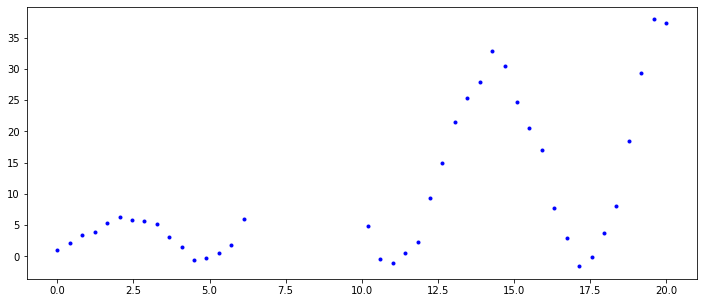

In [3]:
xs, ys = load_dataset(50, drop_data=True)
plt.figure(figsize=[12, 5])
plt.plot(xs, ys, 'b.')

In [4]:
def build_gp(amplitude, length_scale, observation_noise_variance):
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=xs,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

In [5]:
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]

In [6]:
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': ys
  })

In [7]:
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

loss_history = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  loss_history[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Trained parameters:
amplitude: 9.867284391077492
length_scale: 1.4139041678521962
observation_noise_variance: 1.3303347300140023


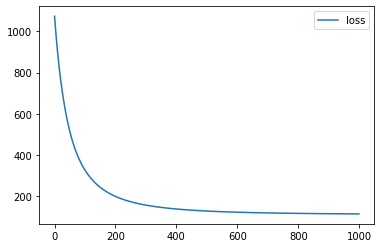

In [8]:
DataFrame({'loss': loss_history}).plot()

In [9]:
sample_xs = np.linspace(*x_range, 200, dtype=np.float64)
sample_xs = sample_xs[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=sample_xs,
    observation_index_points=xs,
    observations=ys,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

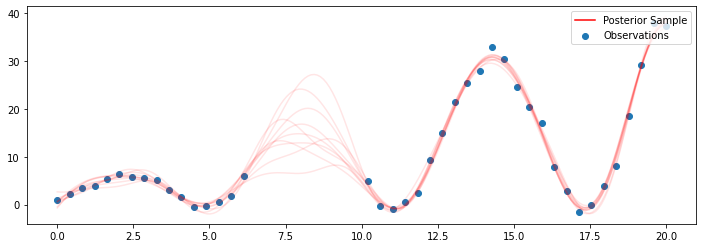

In [13]:
num_samples = 10
samples = gprm.sample(num_samples)

plt.figure(figsize=(12, 4))
plt.scatter(xs[:, 0], ys, label='Observations')
for i in range(num_samples):
  plt.plot(sample_xs, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()